   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.1 MB/s eta 0:00:00
Mounted at /content/drive
Loaded 2916 training and 729 test images.
Classes mapping: ['Calculus', 'Gingivitis']
Epoch 01/20 │ Train loss 0.6502 │ Test loss 0.6650 │ Acc 63.5%
Epoch 02/20 │ Train loss 0.6432 │ Test loss 0.6538 │ Acc 62.7%
Epoch 03/20 │ Train loss 0.6357 │ Test loss 0.6597 │ Acc 63.2%
Epoch 04/20 │ Train loss 0.6318 │ Test loss 0.6543 │ Acc 63.6%
Epoch 05/20 │ Train loss 0.6282 │ Test loss 0.6459 │ Acc 64.1%
Epoch 06/20 │ Train loss 0.6221 │ Test loss 0.6426 │ Acc 64.1%
Epoch 07/20 │ Train loss 0.6168 │ Test l

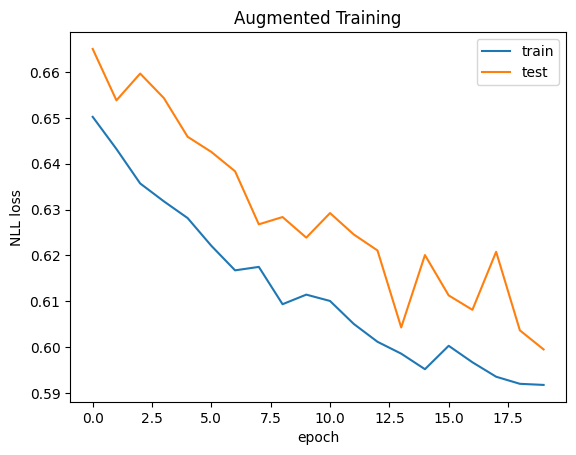

In [1]:
# ─────────────────────────────────────────────────────────────
# 0. Environment – upgrade (Colab users) and imports
# ─────────────────────────────────────────────────────────────
!pip -q install --upgrade "qiskit~=1.0" "qiskit-aer"

import math, os, random, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch, torch.nn as nn, torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import qiskit
from qiskit.circuit import QuantumCircuit as QiskitCircuit, Parameter
from qiskit import transpile
from qiskit_aer import Aer

SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# ─────────────────────────────────────────────────────────────
# 1. Paths & global hyper-parameters
# ─────────────────────────────────────────────────────────────
DATA_DIR   = Path('/content/drive/MyDrive/Colab Notebooks/data')  # expects data/calculus/ and data/gingivitis/
IMG_SIZE   = 32     # images resized to 32×32
BATCH_SIZE = 16
EPOCHS     = 20
LR         = 1e-3
SHOTS      = 100
SHIFT      = math.pi/2

# ─────────────────────────────────────────────────────────────
# 2. Transformations with augmentation for training data
# ─────────────────────────────────────────────────────────────
# Training transform includes augmentation techniques.
train_transform = transforms.Compose([
    # Resize to a slightly bigger image then randomly crop back to IMG_SIZE
    transforms.Resize((IMG_SIZE + 4, IMG_SIZE + 4)),
    transforms.RandomCrop((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    # You can add further augmentation like RandomRotation if desired, for example:
    # transforms.RandomRotation(degrees=15),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Testing transform is kept plain.
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# ─────────────────────────────────────────────────────────────
# 3. Dataset & loaders using custom subsets for different transforms
# ─────────────────────────────────────────────────────────────
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the full dataset WITHOUT assigning a transform.
full_ds = datasets.ImageFolder(DATA_DIR)

# Create a custom dataset class to allow different transforms
class AugmentedSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label

# Split dataset indices into train and test
num_total = len(full_ds)
num_train = int(0.8 * num_total)
indices = list(range(num_total))
random.shuffle(indices)
train_indices = indices[:num_train]
test_indices  = indices[num_train:]

# Create training and test subsets with respective transforms
train_ds = AugmentedSubset(full_ds, train_indices, transform=train_transform)
test_ds  = AugmentedSubset(full_ds, test_indices, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

print(f'Loaded {len(train_ds)} training and {len(test_ds)} test images.')
print('Classes mapping:', full_ds.classes)   # e.g. ['calculus', 'gingivitis']

# ─────────────────────────────────────────────────────────────
# 4. Hybrid quantum block
# ─────────────────────────────────────────────────────────────
class QuantumCircuitWrapper:
    def __init__(self, n_qubits, backend, shots):
        self.theta = Parameter('θ')
        qc = QiskitCircuit(n_qubits, n_qubits)
        for q in range(n_qubits):
            qc.h(q)
            qc.ry(self.theta, q)
        qc.measure(range(n_qubits), range(n_qubits))
        self.circuit = qc
        self.backend = backend
        self.shots   = shots

    def run(self, theta_val):
        bound = self.circuit.assign_parameters({self.theta: theta_val})
        job   = self.backend.run(bound, shots=self.shots)
        counts = job.result().get_counts()
        exp_z  = 0
        if counts:
            probs = {k: v / self.shots for k, v in counts.items()}
            exp_z = sum(((-1) ** int(bit)) * p for bit, p in probs.items())
        return exp_z

class HybridFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, qc, shift):
        theta = input.item()
        ctx.qc, ctx.shift = qc, shift
        exp_val = qc.run(theta)
        ctx.save_for_backward(input, torch.tensor(exp_val))
        return torch.tensor([exp_val], dtype=torch.float32)

    @staticmethod
    def backward(ctx, grad_output):
        (input, _) = ctx.saved_tensors
        theta, shift, qc = input.item(), ctx.shift, ctx.qc
        grad = (qc.run(theta + shift) - qc.run(theta - shift)) / (2 * shift)
        return grad_output * torch.tensor([grad]), None, None

class HybridLayer(nn.Module):
    def __init__(self):
        super().__init__()
        backend = Aer.get_backend('aer_simulator')
        self.qc = QuantumCircuitWrapper(1, backend, SHOTS)

    def forward(self, x):
        return HybridFunction.apply(x, self.qc, SHIFT)

# ─────────────────────────────────────────────────────────────
# 5. CNN + Hybrid network (fc1 size resolves automatically)
# ─────────────────────────────────────────────────────────────
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1   = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2   = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()

        # Compute flattened size dynamically.
        with torch.no_grad():
            dummy = torch.zeros(1, 1, IMG_SIZE, IMG_SIZE)
            out   = F.max_pool2d(F.relu(self.conv1(dummy)), 2)
            out   = F.max_pool2d(F.relu(self.conv2(out)), 2)
            self.flatten_dim = out.numel()

        self.fc1    = nn.Linear(self.flatten_dim, 64)
        self.fc2    = nn.Linear(64, 1)
        self.hybrid = HybridLayer()

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.dropout(x).view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Batch-wise hybrid execution
        outs = [self.hybrid(xi) for xi in x]
        x = torch.stack(outs)           # shape [B, 1]
        x = torch.cat((x, 1 - x), dim=1)
        return F.log_softmax(x, dim=1)

# ─────────────────────────────────────────────────────────────
# 6. Train / evaluate helpers
# ─────────────────────────────────────────────────────────────
def train_epoch(model, loader, opt, criterion):
    model.train(); losses = []
    for data, target in loader:
        opt.zero_grad()
        loss = criterion(model(data), target)
        loss.backward(); opt.step()
        losses.append(loss.item())
    return np.mean(losses)

def evaluate(model, loader, criterion):
    model.eval(); losses, correct = [], 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            losses.append(criterion(output, target).item())
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    return np.mean(losses), correct / len(loader.dataset) * 100

# ─────────────────────────────────────────────────────────────
# 7. Run training loop
# ─────────────────────────────────────────────────────────────
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.NLLLoss()

train_curve, test_curve = [], []
for epoch in range(1, EPOCHS + 1):
    tr_loss = train_epoch(model, train_loader, optimizer, criterion)
    te_loss, te_acc = evaluate(model, test_loader, criterion)
    train_curve.append(tr_loss); test_curve.append(te_loss)
    print(f'Epoch {epoch:02d}/{EPOCHS} │ '
          f'Train loss {tr_loss:.4f} │ Test loss {te_loss:.4f} │ Acc {te_acc:.1f}%')

# ─────────────────────────────────────────────────────────────
# 8. Plot convergence
# ─────────────────────────────────────────────────────────────
plt.plot(train_curve, label='train')
plt.plot(test_curve,  label='test')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('NLL loss'); plt.title('Augmented Training');
plt.show()